## Modelling a single cell in the Arabidopsis shoot apical meristem


In [1]:
### import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import pandas as pd

import modelbase
from modelbase.ode import Model, LabelModel, LinearLabelModel, Simulator, mca

## dictionary of parameters

In [2]:
param = [# parameter values as given by Liu et al
    {'tcw': 0.2, 'ncw': 6, 'kcr':0.5, 'tcl':0.24, 'ncl':6, 'tch':0.13, 'nch':5, 'kcp':2.7, 
          'bcp':1, 'bcr':0.5, 'kwl':1, 'kwc':1, 'kwr':1.2, 'tww':0.53, 'nww':2, 'twl':0.29, 'nwl':6, 
          'twc':0.1, 'nwc':6, 'kwp':0.345, 'bwp':0.4, 'bwr':1, 'k0w':0.3, 'ac':0, 'thw':0.3, 'nhw':4, 
          'bhp':1, 'khp':1, 'bhw':1, 'khw':1, 'klp':10, 'blp':1.5, 'dwp':1, 'dcp':6, 'dlp':1.2}]

## dictionary of starting values for the individual compounds: 

In [3]:
comp_t0 = [{"Wr":0, "Wp":0, "Cr":0, "Cp":0, "Ep":0, "Hp":0},
           {"Wr":1, "Wp":1, "Cr":1, "Cp":1, "Ep":1, "Hp":1},
           {"Wr":0, "Wp":0, "Cr":0, "Cp":7, "Ep":0, "Hp":0},
           {"Wr":5, "Wp":0, "Cr":0, "Cp":0, "Ep":0, "Hp":0}]          

## Defining individual functions for compound synthesis and degradation:

In [4]:
## function 1a: 
def Wpsyn(Wr, kwp):
    Wp = kwp * Wr
    return Wp
def Wpdeg(Wp, bwp):
    Wp = bwp * Wp
    return Wp

## function 1b: 
def Cpsyn(Cr, kcp):
    Cp = kcp * Cr
    return Cp
def Cpdeg(Cp, bcp):
    Cp = bcp * Cp
    return Cp

## function 1c:
def Wrsyn(Ep, Cp, Wp, kwr, kwl, twl, nwl, kwc, twc, nwc, k0w, tww, nww):
    maxWrsyn = kwr
    EponWrsyn = kwl/(1+(Ep/twl)**nwl)
    CponWrsyn = kwc/(1+(Cp/twc)**nwc)
    k0w = k0w
    Wauto1 = (Wp/tww)**nww
    Wauto2 = 1 + (Wp/tww)**nww
    Wr = maxWrsyn * (EponWrsyn + CponWrsyn) * (k0w + (Wauto1/Wauto2))
    return Wr
def Wrdeg(Wr, bwr):
    Wr = bwr * Wr
    return Wr

# reaction 1d:
def Crsyn(Ep, Wp, Hp, kcr, tcl, ncl, ac, tcw, ncw, tch, nch):
    maxCrsyn = kcr
    EponCrsyn = 1/(1 + (Ep/tcl) ** ncl)
    ac = ac
    WponCr1 = (Wp/tcw)**ncw
    WponCr2 = 1 + (Wp/tcw)**ncw
    HponCr = 1/(1 + (Hp/tch)**nch)
    Cr = maxCrsyn * EponCrsyn * (ac + WponCr1/WponCr2) * HponCr
    return Cr
def Crdeg(Cr, bcr):
    Cr = bcr * Cr
    return Cr
    
## function 1e:
def Epsyn(klp):
    Ep = klp * 1
    return Ep
def Epdeg(Ep, blp):
    Ep = blp * Ep
    return Ep

## function 1f:
def Hpsyn(khp):
    Hp = khp * 1
    return Hp
def Hpdeg(Hp, bhp):
    Hp = bhp * Hp
    return Hp

## form model with modelbase

In [5]:
m = Model()
m.add_parameters(param[0])
m.add_compounds(["Wr", "Wp", "Cr", "Cp", "Ep", "Hp"])

# reaction 1a:
m.add_reaction(
    rate_name = 'WUS prot syn', 
    function = Wpsyn,
    stoichiometry = {"Wp":1},
    dynamic_variables = ["Wr"],
    parameters = ["kwp"], # 
    reversible = False)
m.add_reaction(
    rate_name= 'WUS prot deg', 
    function= Wpdeg, 
    stoichiometry= {"Wp": -1}, 
    dynamic_variables= ["Wp"], 
    parameters= ["bwp"], 
    reversible= False)

# reaction 1b:  
m.add_reaction(
    rate_name= 'CLV3 pep syn', 
    function = Cpsyn, 
    stoichiometry= {"Cp": 1}, 
    dynamic_variables= ["Cr"], 
    parameters= ["kcp"],
    reversible= False)
m.add_reaction(
    rate_name= 'CLV3 pep deg', 
    function= Cpdeg, 
    stoichiometry= {"Cp": -1}, 
    dynamic_variables= ["Cp"],
    parameters= ["bcp"], 
    reversible = False)

# reaction 1c: 
m.add_reaction(
    rate_name= 'WUS RNA syn',
    function= Wrsyn,
    stoichiometry= {"Wr": 1},
    dynamic_variables= ["Ep", "Cp", "Wp"],
    parameters= ["kwr", "kwl", "twl", "nwl", "kwc", "twc", "nwc", "k0w", "tww", "nww"], 
    reversible = False)
m.add_reaction(
    rate_name= 'WUS RNA deg',
    function= Wrdeg,
    stoichiometry= {"Wr": -1},
    dynamic_variables= ["Wr"] ,
    parameters= ["bwr"], 
    reversible = False)

# reaction 1d:
m.add_reaction(
    rate_name= 'CLV3 RNA syn',
    function= Crsyn,
    stoichiometry= {"Cr":1},
    dynamic_variables= ["Ep", "Wp", "Hp"],
    parameters= ["kcr", "tcl", "ncl", "ac", "tcw", "ncw", "tch", "nch"], 
    reversible = False)
m.add_reaction(
    rate_name= 'CLV3 RNA deg',
    function= Crdeg,
    stoichiometry= {"Cr": -1},
    dynamic_variables= ["Cr"],
    parameters= ["bcr"], 
    reversible = False)

# reaction 1e:
m.add_reaction(
    rate_name= 'EPFL prot syn',
    function= Epsyn,
    stoichiometry= {"Ep":1},
    dynamic_variables= [],
    parameters= ["klp"], 
    reversible = False)
m.add_reaction(
    rate_name= 'EPFL prot deg',
    function= Epdeg,
    stoichiometry= {"Ep":-1},
    dynamic_variables= ["Ep"],
    parameters= ["blp"], 
    reversible = False)

# reaction 1f:
m.add_reaction(
    rate_name= 'HAM prot syn',
    function= Hpsyn,
    stoichiometry= {"Hp": 1},
    dynamic_variables= [],
    parameters= ["khp"], 
    reversible = False)
m.add_reaction(
    rate_name= 'HAM prot deg',
    function= Hpdeg,
    stoichiometry= {"Hp":-1},
    dynamic_variables= ["Hp"],
    parameters= ["bhp"], 
    reversible = False)

In [6]:
m.get_stoichiometric_df()

CLV3 RNA deg  CLV3 RNA syn  CLV3 pep deg  CLV3 pep syn  EPFL prot deg  \
Cp           0.0           0.0          -1.0           1.0            0.0   
Cr          -1.0           1.0           0.0           0.0            0.0   
Ep           0.0           0.0           0.0           0.0           -1.0   
Hp           0.0           0.0           0.0           0.0            0.0   
Wp           0.0           0.0           0.0           0.0            0.0   
Wr           0.0           0.0           0.0           0.0            0.0   

    EPFL prot syn  HAM prot deg  HAM prot syn  WUS RNA deg  WUS RNA syn  \
Cp            0.0           0.0           0.0          0.0          0.0   
Cr            0.0           0.0           0.0          0.0          0.0   
Ep            1.0           0.0           0.0          0.0          0.0   
Hp            0.0          -1.0           1.0          0.0          0.0   
Wp            0.0           0.0           0.0          0.0          0.0   
Wr            0.0           0.0           0.0         -1.0          1.0   

    WUS prot deg  WUS prot syn  
Cp           0.0           0.0  
Cr           0.0           0.0  
Ep           0.0           0.0  
Hp           0.0           0.0  
Wp          -1.0           1.0  
Wr           0.0           0.0

In [7]:
m.get_fluxes_df(comp_t0[0], t = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

WUS prot syn  WUS prot deg  CLV3 pep syn  CLV3 pep deg  WUS RNA syn  \
0           0.0           0.0           0.0           0.0         0.72   
1           0.0           0.0           0.0           0.0         0.72   
2           0.0           0.0           0.0           0.0         0.72   
3           0.0           0.0           0.0           0.0         0.72   
4           0.0           0.0           0.0           0.0         0.72   
5           0.0           0.0           0.0           0.0         0.72   
6           0.0           0.0           0.0           0.0         0.72   
7           0.0           0.0           0.0           0.0         0.72   
8           0.0           0.0           0.0           0.0         0.72   
9           0.0           0.0           0.0           0.0         0.72   

   WUS RNA deg  CLV3 RNA syn  CLV3 RNA deg  EPFL prot syn  EPFL prot deg  \
0          0.0           0.0           0.0           10.0            0.0   
1          0.0           0.0           0.0           10.0            0.0   
2          0.0           0.0           0.0           10.0            0.0   
3          0.0           0.0           0.0           10.0            0.0   
4          0.0           0.0           0.0           10.0            0.0   
5          0.0           0.0           0.0           10.0            0.0   
6          0.0           0.0           0.0           10.0            0.0   
7          0.0           0.0           0.0           10.0            0.0   
8          0.0           0.0           0.0           10.0            0.0   
9          0.0           0.0           0.0           10.0            0.0   

   HAM prot syn  HAM prot deg  
0           1.0           0.0  
1           1.0           0.0  
2           1.0           0.0  
3           1.0           0.0  
4           1.0           0.0  
5           1.0           0.0  
6           1.0           0.0  
7           1.0           0.0  
8           1.0           0.0  
9           1.0           0.0

## Figures for different compound starting values: 

In [8]:
handles = ["WUS mRNA", "WUS protein", "CLV3 mRNA", "CLV3 peptide", "EPFL peptide", "HAM protein"]

fig, ax = plt.subplots(4,1, figsize = (8,10))

for i in range(len(comp_t0)):
    c = comp_t0[i] # take parameters for the i-th scenario
    # m.update_parameters(c) # m is the result of plugging the values of the i-th scenario into previously defined modelling function
    s = Simulator(m) # start simulator with the model
    s.initialise(comp_t0[i]) 
    t_m,res_m = s.simulate(50)
    ax[i].plot(t_m,res_m)
    ax[i].set_xlabel('Time [a.u.]', fontsize = 12)
    ax[i].set_ylabel('Compound abundance [a.u.]', fontsize = 12)
    ax[i].set_ylim(top = 8)
    if ax[0]:
        ax[0].set_title('Starting values = 0', fontsize = 14)
    if ax[1]:
        ax[0].set_title('Starting values = 1', fontsize = 14)
    if ax[1]:
        ax[1].set_title('Starting values = 0, CLV3 peptide = 7', fontsize = 14)
    if ax[2]:
        ax[2].set_title('Starting values = 0, WUS mRNA = 5', fontsize = 14)

plt.legend(handles, bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)
plt.tight_layout()
plt.style.use('seaborn-whitegrid')
#plt.show()
plt.savefig('extreme_Cr_or_Wp_fin.pdf')
plt.show() # show plot
    


# fig.title('different starting values', fontsize=16)

# fig.suptitle('different starting values', fontsize=16)

## Figures for altered parameter values (different meristem areas):

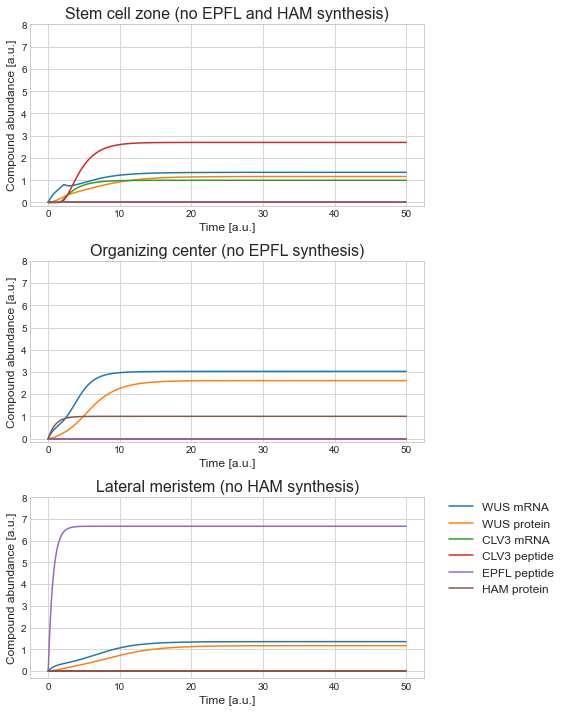

In [9]:
param = [ # no EPFL production, no HAM protein: (SC zone)
       {'tcw': 0.2, 'ncw': 6, 'kcr':0.5, 'tcl':0.24, 'ncl':6, 'tch':0.13, 'nch':5, 'kcp':2.7, 
          'bcp':1, 'bcr':0.5, 'kwl':1, 'kwc':1, 'kwr':1.2, 'tww':0.53, 'nww':2, 'twl':0.29, 'nwl':6, 
          'twc':0.1, 'nwc':6, 'kwp':0.345, 'bwp':0.4, 'bwr':1, 'k0w':0.3, 'ac':0, 'thw':0.3, 'nhw':4, 
          'bhp':1, 'khp':0, 'bhw':1, 'khw':1, 'klp':0, 'blp':1.5, 'dwp':1, 'dcp':6, 'dlp':1.2},
    
        # no EPFL production: (Rib meristem/OC)
        {'tcw': 0.2, 'ncw': 6, 'kcr':0.5, 'tcl':0.24, 'ncl':6, 'tch':0.13, 'nch':5, 'kcp':2.7, 
          'bcp':1, 'bcr':0.5, 'kwl':1, 'kwc':1, 'kwr':1.2, 'tww':0.53, 'nww':2, 'twl':0.29, 'nwl':6, 
          'twc':0.1, 'nwc':6, 'kwp':0.345, 'bwp':0.4, 'bwr':1, 'k0w':0.3, 'ac':0, 'thw':0.3, 'nhw':4, 
          'bhp':1, 'khp':1, 'bhw':1, 'khw':1, 'klp':0, 'blp':1.5, 'dwp':1, 'dcp':6, 'dlp':1.2},
    
        # lateral meristem (no HAM synthesis)
        {'tcw': 0.2, 'ncw': 6, 'kcr':0.5, 'tcl':0.24, 'ncl':6, 'tch':0.13, 'nch':5, 'kcp':2.7, 
          'bcp':1, 'bcr':0.5, 'kwl':1, 'kwc':1, 'kwr':1.2, 'tww':0.53, 'nww':2, 'twl':0.29, 'nwl':6, 
          'twc':0.1, 'nwc':6, 'kwp':0.345, 'bwp':0.4, 'bwr':1, 'k0w':0.3, 'ac':0, 'thw':0.3, 'nhw':4, 
          'bhp':1, 'khp':0, 'bhw':1, 'khw':1, 'klp':10, 'blp':1.5, 'dwp':1, 'dcp':6, 'dlp':1.2}]
    
    
comp_t0 = [{"Wr":0, "Wp":0, "Cr":0, "Cp":0, "Ep":0, "Hp":0}]


handles = ["WUS mRNA", "WUS protein", "CLV3 mRNA", "CLV3 peptide", "EPFL peptide", "HAM protein"]

fig, ax = plt.subplots(3,1, figsize = (8,10))

for i in range(len(param)):
    c = param[i] # take parameters for the i-th scenario
    m.update_parameters(c)
    s = Simulator(m) 
    s.initialise(comp_t0[0]) 
    t_m,res_m = s.simulate(50)
    ax[i].plot(t_m,res_m)
    ax[i].set_xlabel('Time [a.u.]', fontsize = 12)
    ax[i].set_ylabel('Compound abundance [a.u.]', fontsize = 12)
    ax[i].set_ylim(top = 8)
    if ax[0]:
        ax[0].set_title('Stem cell zone (no EPFL and HAM synthesis)', fontsize = 16)
    if ax[1]:
        ax[1].set_title('Organizing center (no EPFL synthesis)', fontsize = 16)
    if ax[2]:
        ax[2].set_title('Lateral meristem (no HAM synthesis)', fontsize = 16)

plt.legend(handles, bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., fontsize = 12)
plt.tight_layout()
plt.style.use('seaborn-whitegrid')
plt.savefig('new_lateral_diff_celltypes.pdf')
plt.show() # show plot